<a href="https://colab.research.google.com/github/abajr516/Google4/blob/main/DataPreprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Machine Learning Problem** : predict the revenue generated by the customer (in dollars) when s/he visits the store

**Ref Source** : https://www.kaggle.com/competitions/ga-customer-revenue-prediction/overview

Loading data from Kaggle : I downloaded my API token from Kaggle (kaggle.json) and ran the following commands to be able to download the data directly from Kaggle on Google Colab

Ref : https://www.analyticsvidhya.com/blog/2021/06/how-to-load-kaggle-datasets-directly-into-google-colab/

In [ ]:
! pip install kaggle

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle competitions download -c ga-customer-revenue-prediction

100% 1.56G/1.56G [00:56<00:00, 35.8MB/s]
100% 1.56G/1.56G [00:56<00:00, 29.8MB/s]


In [ ]:
! unzip ga-customer-revenue-prediction.zip

Archive:  ga-customer-revenue-prediction.zip
  inflating: sample_submission.csv   
  inflating: sample_submission_v2.csv  
  inflating: test.csv                
  inflating: test_v2.csv             
  inflating: train.csv               
  inflating: train_v2.csv            


Importing libraries we might need

In [ ]:
# importing libraries

import os
import json
import gc
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as st
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import RandomForestClassifier


We can see that four features in the train & test datasets are in the JSON form - 'device', 'geoNetwork', 'totals', 'trafficSource. These features need to be flattened out. We have a refernce function written which I am going to be using for this : https://www.kaggle.com/julian3833/1-quick-start-read-csv-and-flatten-json-fields/notebook

In [ ]:
def load_df(csv_path, nrows=None):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']

    df = pd.read_csv(csv_path,
                     converters={column: json.loads for column in JSON_COLUMNS},
                     dtype={'fullVisitorId': 'str'}, # Important!!
                     nrows=nrows,
                     on_bad_lines='skip')

    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    print(f"Loaded {os.path.basename(csv_path)}. Shape: {df.shape}")
    return df

Creating Train and Test Dataframes

Creating a smaller dataframe for the ease of use

We would be using Pandas Dataframe : for more information please read https://towardsdatascience.com/why-and-how-to-use-pandas-with-large-data-9594dda2ea4c

In [ ]:
small_train_df = load_df('/content/train_v2.csv', nrows = 200000)

<ipython-input-9-3a68f20ff476>:11: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead.
  column_as_df = json_normalize(df[column])
<ipython-input-9-3a68f20ff476>:11: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead.
  column_as_df = json_normalize(df[column])
<ipython-input-9-3a68f20ff476>:11: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead.
  column_as_df = json_normalize(df[column])
<ipython-input-9-3a68f20ff476>:11: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead.
  column_as_df = json_normalize(df[column])


Loaded train_v2.csv. Shape: (200000, 60)


Quick data check - makes use realize that there columns we can drop and

In [ ]:
small_train_df

,channelGrouping,customDimensions,date,fullVisitorId,hits,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,...,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.referralPath,trafficSource.isTrueDirect,trafficSource.adContent,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.campaignCode
0,Organic Search,"[{'index': '4', 'value': 'EMEA'}]",20171016,3162355547410993243,"[{'hitNumber': '1', 'time': '0', 'hour': '17',...",Not Socially Engaged,1508198450,1,1508198450,Firefox,...,not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Referral,"[{'index': '4', 'value': 'North America'}]",20171016,8934116514970143966,"[{'hitNumber': '1', 'time': '0', 'hour': '10',...",Not Socially Engaged,1508176307,6,1508176307,Chrome,...,not available in demo dataset,/a/google.com/transportation/mtv-services/bike...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Direct,"[{'index': '4', 'value': 'North America'}]",20171016,7992466427990357681,"[{'hitNumber': '1', 'time': '0', 'hour': '17',...",Not Socially Engaged,1508201613,1,1508201613,Chrome,...,not available in demo dataset,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Organic Search,"[{'index': '4', 'value': 'EMEA'}]",20171016,9075655783635761930,"[{'hitNumber': '1', 'time': '0', 'hour': '9', ...",Not Socially Engaged,1508169851,1,1508169851,Chrome,...,not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Organic Search,"[{'index': '4', 'value': 'Central America'}]",20171016,6960673291025684308,"[{'hitNumber': '1', 'time': '0', 'hour': '14',...",Not Socially Engaged,1508190552,1,1508190552,Chrome,...,not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,Social,[],20161022,8020383777296340615,"[{'hitNumber': '1', 'time': '0', 'hour': '8', ...",Not Socially Engaged,1477150726,1,1477150726,Chrome,...,not available in demo dataset,/yt/about/vi/,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
199996,Social,[],20161022,955669462790250179,"[{'hitNumber': '1', 'time': '0', 'hour': '15',...",Not Socially Engaged,1477177148,1,1477177148,Chrome,...,not available in demo dataset,/yt/about/ko/,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
199997,Social,[],20161022,4875730453124115574,"[{'hitNumber': '1', 'time': '0', 'hour': '18',...",Not Socially Engaged,1477187702,1,1477187702,Chrome,...,not available in demo dataset,/yt/about/es/index.html,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
199998,Social,[],20161022,5057460011027299576,"[{'hitNumber': '1', 'time': '0', 'hour': '4', ...",Not Socially Engaged,1477134135,1,1477134135,Chrome,...,not available in demo dataset,/yt/about/vi/,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
colss= ['date', 'visitStartTime']

In [ ]:
small_train_df[colss]

,date,visitStartTime
0,20171016,1508198450
1,20171016,1508176307
2,20171016,1508201613
3,20171016,1508169851
4,20171016,1508190552
...,...,...
199995,20161022,1477150726
199996,20161022,1477177148
199997,20161022,1477187702
199998,20161022,1477134135


In [ ]:
small_test_df = load_df('/content/test_v2.csv', nrows = 100000)

<ipython-input-9-3a68f20ff476>:11: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead.
  column_as_df = json_normalize(df[column])
<ipython-input-9-3a68f20ff476>:11: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead.
  column_as_df = json_normalize(df[column])
<ipython-input-9-3a68f20ff476>:11: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead.
  column_as_df = json_normalize(df[column])
<ipython-input-9-3a68f20ff476>:11: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead.
  column_as_df = json_normalize(df[column])


Loaded test_v2.csv. Shape: (100000, 59)


Getting a list of all the column names

In [ ]:
def extract_date(small_train_df):
  # Convert date feature into datetime format
  small_train_df["date"] = pd.to_datetime(small_train_df["date"], infer_datetime_format=True, format="%Y%m%d")
  # Extract month as a column
  small_train_df["month"] = small_train_df["date"].dt.month
  # Extract year as a column
  small_train_df["year"] = small_train_df["date"].dt.year
  # Convert visitStartTime into datetime format
  small_train_df["visitStartTime"] = pd.to_datetime(small_train_df['visitStartTime'], unit='s')
  # Extract hour of day as a column
  small_train_df["hour"] = small_train_df["visitStartTime"].dt.hour
  # Drop data and visitStartTime
  #small_train_df=small_train_df.drop(columns=['date', 'visitStartTime'], axis=1)
  return small_train_df

In [ ]:
# Find columns to drop
# Expecting training dataset as a parameter
# Returns a list of the columns dropped to be dropped outside of the function

def columns_to_drop(small_train_df):
  columns_dropped = []
  # Checking percent missing
  percent_missing = small_train_df.isnull().sum() * 100 / len(small_train_df)  #{ (total nulls in particular column*100)/total no.of rows }
  missing_value = pd.DataFrame({'column_name': small_train_df.columns, 'percent_missing': percent_missing})
  # Remove all columns that have percent missing above 60%
  for index, row in missing_value.iterrows():
    if row['percent_missing'] > 60 and row['column_name']!='totalTransactionRevenue':
      columns_dropped.append(row['column_name'])
  # Remove all columns that have only 1 unique value2
  for column in small_train_df.columns:
    count = small_train_df[column].nunique()
    if count==1:
      columns_dropped.append(column)
  columns_dropped.remove('totals.totalTransactionRevenue')
  return columns_dropped

In [ ]:
# Rename columns that were extracted from jsons to make them clearer
def rename_cols(df):
  original = []
  new = []
  for i in df.columns:
    original.append(i)
    x = i.split(".")
    new_i = x[-1]
    new.append(new_i)
  rename_dict = dict(zip(original, new))
  renamed_df=df.rename(columns=rename_dict)
  return renamed_df

In [ ]:
# Fill NaN values with apppropriate value, either 0 or mean
# Apply to both training and testing datasets
# Don't forget to check the dtypes of these columns after running function to make sure it converted
def fill_df(small_train_df_tst):
  small_train_df_tst["totalTransactionRevenue"] = small_train_df_tst["totalTransactionRevenue"].astype(float).fillna(0.0)
  small_train_df_tst["pageviews"] = small_train_df_tst["pageviews"].astype(float).fillna(0.0)
  small_train_df_tst["sessionQualityDim"] = small_train_df_tst["sessionQualityDim"].fillna(0)
  small_train_df_tst["timeOnSite"] = small_train_df_tst["timeOnSite"].fillna(0)
  return small_train_df_tst


In [ ]:
# Creates list of numeric columns
# Only expecting training dataset as input
def find_num_features(df):
  int_features_list = list(df.select_dtypes(include=['int64', 'float64']))
  int_features_list.remove('totalTransactionRevenue')
  return int_features_list

In [ ]:
# Add min, max, mean after grouping by fullVisitorID
# Expected to take in both training and testing datasets.
def add_numeric_cols(small_train_df, int_features_list):
  for i in int_features_list:
    small_train_df[i+'_max'] = small_train_df.groupby('fullVisitorId')[i].transform('max')
    small_train_df[i+'_min'] = small_train_df.groupby('fullVisitorId')[i].transform('min')
    small_train_df[i+'_avg'] = small_train_df.groupby('fullVisitorId')[i].transform('mean')
    small_train_df=small_train_df.drop(i, axis=1)
  return small_train_df

In [ ]:
def encode_df(small_train_df):
  to_encode_lst = list(small_train_df.select_dtypes(include="object"))
  one_hot_list = ['channelGrouping', 'customDimensions', 'deviceCategory', 'continent', 'medium']
  one_hot_list2 = ['browser', 'operatingSystem', 'source']
  for i in one_hot_list:
    to_encode_lst.remove(i)
  for j in one_hot_list2:
    to_encode_lst.remove(j)
  to_drop_lst = to_encode_lst
  small_train_df = small_train_df.drop(columns=to_drop_lst, axis=1)
  other1=small_train_df['browser'].value_counts().index[3:]
  for k in other1:
    small_train_df['browser'] = small_train_df['browser'].replace(k, 'Other')
  other2 = small_train_df['operatingSystem'].value_counts().index[4:]
  for a in other2:
    small_train_df['operatingSystem'] = small_train_df['operatingSystem'].replace(a, 'Other')
  other3 = small_train_df['source'].value_counts().index[3:]
  for b in other3:
    small_train_df['source'] = small_train_df['source'].replace(b, 'Other')
  to_encode_lst=one_hot_list+one_hot_list2
  # Create the encoder:
  encoder = OneHotEncoder(handle_unknown="error", sparse=False)
  # Apply the encoder:
  df_enc = pd.DataFrame(encoder.fit_transform(small_train_df[to_encode_lst]))
  # Reinstate the original column names:
  df_enc.columns = encoder.get_feature_names_out(to_encode_lst)
  # Concatenate with the encoded dataframe:
  small_train_df = small_train_df.join(df_enc)
  # Remove the original categorical features from X_train and X_test:
  small_train_df = small_train_df.drop(columns = to_encode_lst ,axis=1)
  return small_train_df

In [ ]:
def aggregate_df(small_train_df):
  small_train_df['totalTransactionRevenue'] = small_train_df.groupby('fullVisitorId')['totalTransactionRevenue'].transform('sum')
  cols = list(small_train_df.columns)
  small_train_df_grpb = small_train_df.groupby('fullVisitorId', as_index=False)[cols].first()
  return small_train_df_grpb

In [ ]:
#Column for whether or not user spends money
def convert_to_binary(value):
  if value ==0:
    return 0
  else:
    return 1

In [ ]:
def convert_to_numerical(value):
  if value ==False:
    return 0
  else:
    return 1

In [ ]:
def clean_df(small_train_df):
  small_train_df['fullVisitorId'] = small_train_df['fullVisitorId'].astype('string')
  small_train_df_tst = small_train_df.drop(columns = "hits")
  small_train_df_tst = extract_date(small_train_df_tst)
  columns_dropped = columns_to_drop(small_train_df_tst)
  small_train_df_tst = small_train_df_tst.drop(columns=columns_dropped, axis=1)
  small_train_df_tst=rename_cols(small_train_df_tst)
  small_train_df_tst=fill_df(small_train_df_tst)
  num_cols_lst = find_num_features(small_train_df_tst)
  small_train_df_tst=add_numeric_cols(small_train_df_tst, num_cols_lst)
  small_train_df_tst=encode_df(small_train_df_tst)
  small_train_df_tst=aggregate_df(small_train_df_tst)
  small_train_df_tst['Spend?'] = small_train_df_tst['totalTransactionRevenue'].apply(convert_to_binary)
  small_train_df_tst['isMobile'] = small_train_df_tst['isMobile'].apply(convert_to_numerical)
  return small_train_df_tst

In [ ]:
train_df = clean_df(small_train_df)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
train_df.columns

Index(['date', 'fullVisitorId', 'visitStartTime', 'isMobile',
       'totalTransactionRevenue', 'visitId_max', 'visitId_min', 'visitId_avg',
       'visitNumber_max', 'visitNumber_min', 'visitNumber_avg',
       'pageviews_max', 'pageviews_min', 'pageviews_avg', 'month_max',
       'month_min', 'month_avg', 'year_max', 'year_min', 'year_avg',
       'hour_max', 'hour_min', 'hour_avg', 'channelGrouping_(Other)',
       'channelGrouping_Affiliates', 'channelGrouping_Direct',
       'channelGrouping_Display', 'channelGrouping_Organic Search',
       'channelGrouping_Paid Search', 'channelGrouping_Referral',
       'channelGrouping_Social', 'customDimensions_[]',
       'customDimensions_[{'index': '4', 'value': 'APAC'}]',
       'customDimensions_[{'index': '4', 'value': 'Central America'}]',
       'customDimensions_[{'index': '4', 'value': 'EMEA'}]',
       'customDimensions_[{'index': '4', 'value': 'North America'}]',
       'customDimensions_[{'index': '4', 'value': 'South America'}]'

In [ ]:
cols = ['browser_Chrome', 'browser_Firefox','browser_Safari','browser_Other']

In [ ]:
train_df[cols]

,browser_Chrome,browser_Firefox,browser_Safari,browser_Other
0,1.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0
4,1.0,0.0,0.0,0.0
...,...,...,...,...
177047,0.0,0.0,1.0,0.0
177048,0.0,0.0,1.0,0.0
177049,1.0,0.0,0.0,0.0
177050,0.0,0.0,1.0,0.0


In [ ]:
train_df[train_df['totalTransactionRevenue'] > 0][cols]

,date,fullVisitorId,visitStartTime,totalTransactionRevenue,visitId_max,visitId_min,visitId_avg
128,2017-05-01,0007933257389091624,2017-05-01 18:45:33,37590000.0,1493664333,1493664333,1.493664e+09
221,2017-10-16,0012276352424581690,2017-10-16 17:50:15,53980000.0,1508176215,1505406174,1.506791e+09
286,2017-04-20,0017260116665815114,2017-04-20 16:54:46,46190000.0,1503458461,1492707286,1.499868e+09
412,2018-01-03,0023593003187413047,2018-01-03 21:34:50,263800000.0,1515015290,1515015290,1.515015e+09
611,2016-08-22,0036515130282846944,2016-08-22 19:01:37,92500000.0,1471892497,1471892497,1.471892e+09
...,...,...,...,...,...,...,...
176628,2016-12-13,9976366744327936965,2016-12-13 19:37:29,109780000.0,1481657849,1481657849,1.481658e+09
176707,2016-08-11,9980323391675823795,2016-08-11 14:20:34,46330000.0,1470925234,1470925234,1.470925e+09
176863,2018-04-15,9989175626794898064,2018-04-15 20:33:34,24590000.0,1523824414,1523824414,1.523824e+09
176867,2016-10-30,9989256027389985761,2016-10-30 20:05:48,68980000.0,1477881774,1477850840,1.477864e+09


In [ ]:
test_df = clean_df(small_test_df)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
from datetime import datetime, timedelta

In [ ]:
def get_time_series_features(data,k):

    train_frame_k = data.loc[(data['date'] >= min(data['date']) + timedelta(days=168*(k-1))) & (data['date'] < min(data['date'])  + timedelta(days=168*k)) ]

    # for train_frame_1 = aug 1st 2016 to jan 15 th 2017
    #in code k=1 and min(data['date']) = aug 1st 2016
    # so it return from aug 1st 2016 to jan 15 th 2017 (since: aug 1st 2016+168)

    test_frame_k = data.loc[(data['date'] >= max(train_frame_k['date']) + timedelta(days=46)) & (data['date'] <= max(train_frame_k['date']) + timedelta(days=108))]

    # for test_frame_1 = mar 2nd 2017 to may 3 rd 2017
    #in code max(train_frame_k['date'])=jan 15th 2017
    # so it return from " mar 2nd 2017(since: jan 15 th 2017 + 46)" to "may 3rd 2017(since: jan 15 th 2017 + 108)"

    returned_customers     = set(train_frame_k["fullVisitorId"]) & set(test_frame_k["fullVisitorId"]) # intersection

    non_returned_customers = set(train_frame_k["fullVisitorId"]) - set(test_frame_k["fullVisitorId"]) # subtraction

    # here we will seperate the customers who came to store after cooling peroid untill 64 days after cooling period.
    # Here cooling period means(=46 days) from "train_frame" end date
    # so now we will seperate the "train_frame_k" customers who came back to store in "test_frame_k" period.

    # preparing returned customers data
    returned_customers_data = test_frame_k[test_frame_k['fullVisitorId'].isin(set(returned_customers))]

    returned_customers_transactions = returned_customers_data.groupby('fullVisitorId')[['totalTransactionRevenue']].sum().apply(np.log1p, axis=1).reset_index()

    returned_customers_transactions['is_returned'] = 1

    returned_customers_transactions.rename(columns={'totalTransactionRevenue': 'revenue'}, inplace=True)

    # preparing non-returned customers data

    non_returned_customers_data = pd.DataFrame()

    non_returned_customers_data['fullVisitorId'] = list(set(non_returned_customers))

    non_returned_customers_data['is_returned'] = 0

    non_returned_customers_data['revenue'] = 0

    # so final time based featurizations(for classification model)

    # we are concatinating returned and non-returned users

    classification_features = pd.concat([returned_customers_transactions,
                                         non_returned_customers_data],
                                         axis=0).reset_index(drop=True)

    # featurization for train_frame_k data

    #https://stackoverflow.com/questions/52747805/how-to-get-rid-of-nested-column-names-in-pandas-from-group-by-aggregation

    train_frame_k_maxdate = max(train_frame_k['date'])

    train_frame_k_mindate = min(train_frame_k['date'])

    # Drop the parent level of features. for e.g. drop geoNetwork.networkDomain and keep only 'networkDomain' which stores max value from the group.

    # Assuming you want to drop the only level in the columns
    #train_frame_k.columns = train_frame_k.columns.droplevel()

    # merging the two dataframe tf having features and tf_target having target variables.

    train_frame_k = pd.merge(train_frame_k,
                             classification_features ,
                             left_on='fullVisitorId',
                             right_on='fullVisitorId')

    return train_frame_k

In [ ]:
train_test_data = pd.concat([train_df, test_df], axis=0).reset_index()


In [ ]:
train_test_data.head()

,index,date,fullVisitorId,visitStartTime,isMobile,totalTransactionRevenue,visitId_max,visitId_min,visitId_avg,visitNumber_max,...,operatingSystem_Android,operatingSystem_Macintosh,operatingSystem_Other,operatingSystem_Windows,operatingSystem_iOS,source_(direct),source_Other,source_google,source_youtube.com,Spend?
0,0,2016-11-30,0000020424342248747,2016-12-01 07:55:01,0,0.0,1480578901,1480578901,1.480579e+09,1,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0
1,1,2018-02-21,0000059488412965267,2018-02-21 08:06:17,1,0.0,1519200377,1519200377,1.519200e+09,1,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0
2,2,2017-10-06,0000118334805178127,2017-10-06 21:28:41,1,0.0,1507325321,1507325321,1.507325e+09,1,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
3,3,2016-11-10,0000174067426171406,2016-11-11 06:44:01,1,0.0,1478846641,1478846641,1.478847e+09,1,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0
4,4,2018-03-07,0000174453501096099,2018-03-07 18:55:10,0,0.0,1520448910,1520448910,1.520449e+09,1,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0


In [ ]:
#list(train_test_data.columns)

In [ ]:
train_test_data['date'] = pd.to_datetime(train_test_data['date'])

In [ ]:
train_frame_1 = get_time_series_features(train_test_data, 1)
train_frame_1.to_pickle('train_frame_1')

In [ ]:
train_frame_2 = get_time_series_features(train_test_data,2)
train_frame_2.to_pickle('train_frame_2')

In [ ]:
train_frame_3 = get_time_series_features(train_test_data,3)
train_frame_3.to_pickle('train_frame_3')

In [ ]:
train_frame_4 = get_time_series_features(train_test_data,4)
train_frame_4.to_pickle('train_frame_4')

In [ ]:
small_train_df = pd.concat([train_frame_1, train_frame_2, train_frame_3, train_frame_4], axis=0, sort=False).reset_index(drop=True)

In [ ]:
small_train_df.head()

,index,date,fullVisitorId,visitStartTime,isMobile,totalTransactionRevenue,visitId_max,visitId_min,visitId_avg,visitNumber_max,...,operatingSystem_Other,operatingSystem_Windows,operatingSystem_iOS,source_(direct),source_Other,source_google,source_youtube.com,Spend?,revenue,is_returned
0,0,2016-11-30,0000020424342248747,2016-12-01 07:55:01,0,0.0,1480578901,1480578901,1.480579e+09,1,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0,0.0,0
1,3,2016-11-10,0000174067426171406,2016-11-11 06:44:01,1,0.0,1478846641,1478846641,1.478847e+09,1,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0,0.0,0
2,5,2016-09-02,0000245437374675368,2016-09-03 00:34:02,0,0.0,1472862842,1472862842,1.472863e+09,1,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0,0.0,0
3,7,2016-08-20,0000393882583300244,2016-08-21 00:00:41,0,0.0,1471737641,1471737641,1.471738e+09,1,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0,0.0,0
4,8,2016-11-30,0000485418944539313,2016-11-30 12:43:07,0,0.0,1480509787,1480509787,1.480510e+09,1,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0.0,0


In [ ]:
small_train_df.shape

(203309, 70)

In [ ]:
train_df1 = small_train_df

In [ ]:
#train_df1= train_df1.drop(['visitStartTime', 'date'], axis = 1)

In [ ]:
# Extract numerical features from the datetime
train_df1['year'] = train_df1['date'].dt.year
train_df1['month'] = train_df1['date'].dt.month
train_df1['day'] = train_df1['date'].dt.day

# Drop original datetime feature
train_df1 = train_df1.drop(['date'], axis=1)

# Handle missing values (fill with median for simplicity, you may choose another strategy)
train_df1['year'].fillna(train_df1['year'].median(), inplace=True)
train_df1['month'].fillna(train_df1['month'].median(), inplace=True)
train_df1['day'].fillna(train_df1['day'].median(), inplace=True)

In [ ]:
# Extract numerical features from the datetime
train_df1['year'] = train_df1['visitStartTime'].dt.year
train_df1['month'] = train_df1['visitStartTime'].dt.month
train_df1['day'] = train_df1['visitStartTime'].dt.day

# Drop original datetime feature
train_df1 = train_df1.drop(['visitStartTime'], axis=1)

# Handle missing values (fill with median for simplicity, you may choose another strategy)
train_df1['year'].fillna(train_df1['year'].median(), inplace=True)
train_df1['month'].fillna(train_df1['month'].median(), inplace=True)
train_df1['day'].fillna(train_df1['day'].median(), inplace=True)

In [ ]:
#train_df1 = aggregate_df(train_df1)

In [ ]:
train_df1.shape

(203309, 71)

In [ ]:
train_df1 = train_df1.dropna()

In [ ]:
train_df1.shape

(177052, 71)

In [ ]:
train_df1['fullVisitorId'] = train_df1['fullVisitorId'].astype(float)

<ipython-input-48-41be6a78ee44>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df1['fullVisitorId'] = train_df1['fullVisitorId'].astype(float)


In [ ]:
train_df1.head()

,index,fullVisitorId,isMobile,totalTransactionRevenue,visitId_max,visitId_min,visitId_avg,visitNumber_max,visitNumber_min,visitNumber_avg,...,source_(direct),source_Other,source_google,source_youtube.com,Spend?,revenue,is_returned,year,month,day
0,0,2.042434e+13,0,0.0,1480578901,1480578901,1.480579e+09,1,1,1.0,...,1.0,0.0,0.0,0.0,0,0.0,0,2016,12,1
1,3,1.740674e+14,1,0.0,1478846641,1478846641,1.478847e+09,1,1,1.0,...,1.0,0.0,0.0,0.0,0,0.0,0,2016,11,11
2,5,2.454374e+14,0,0.0,1472862842,1472862842,1.472863e+09,1,1,1.0,...,0.0,0.0,0.0,1.0,0,0.0,0,2016,9,3
3,7,3.938826e+14,0,0.0,1471737641,1471737641,1.471738e+09,1,1,1.0,...,0.0,0.0,0.0,1.0,0,0.0,0,2016,8,21
4,8,4.854189e+14,0,0.0,1480509787,1480509787,1.480510e+09,1,1,1.0,...,1.0,0.0,0.0,0.0,0,0.0,0,2016,11,30


In [ ]:
#train_df1['fullVisitorId'].dtype


In [ ]:
#list(train_df1.dtypes)

In [ ]:
#train_df1.head()

In [ ]:
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint

In [ ]:
import re
df = train_df1.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [ ]:
df.head()

,index,fullVisitorId,isMobile,totalTransactionRevenue,visitId_max,visitId_min,visitId_avg,visitNumber_max,visitNumber_min,visitNumber_avg,...,source_direct,source_Other,source_google,source_youtubecom,Spend,revenue,is_returned,year,month,day
0,0,2.042434e+13,0,0.0,1480578901,1480578901,1.480579e+09,1,1,1.0,...,1.0,0.0,0.0,0.0,0,0.0,0,2016,12,1
1,3,1.740674e+14,1,0.0,1478846641,1478846641,1.478847e+09,1,1,1.0,...,1.0,0.0,0.0,0.0,0,0.0,0,2016,11,11
2,5,2.454374e+14,0,0.0,1472862842,1472862842,1.472863e+09,1,1,1.0,...,0.0,0.0,0.0,1.0,0,0.0,0,2016,9,3
3,7,3.938826e+14,0,0.0,1471737641,1471737641,1.471738e+09,1,1,1.0,...,0.0,0.0,0.0,1.0,0,0.0,0,2016,8,21
4,8,4.854189e+14,0,0.0,1480509787,1480509787,1.480510e+09,1,1,1.0,...,1.0,0.0,0.0,0.0,0,0.0,0,2016,11,30


In [ ]:
#df1 = df.drop([
 #'month_avg',
 #'month_max',
 #'visitNumber_min',
 #'month_min',
 #'month'], axis = 1)

In [ ]:
df.shape

(177052, 71)

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.linear_model import LogisticRegression
import numpy as np
from sklearn.metrics import r2_score

# Assuming you have a DataFrame called 'final_features' with all the engineered features

# Split the data into training and testing sets
X_classification = df.drop(['is_returned', 'revenue', 'totalTransactionRevenue'], axis=1)
y_classification = df['is_returned']

X_regression = df.drop(['revenue'], axis=1)
y_regression = df['totalTransactionRevenue']

X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X_classification, y_classification, test_size=0.2, random_state=42)
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_regression, y_regression, test_size=0.2, random_state=42)

# Train the classification model (Logistic Regression as an example)
classifier = LogisticRegression()
classifier.fit(X_train_class, y_train_class)

# Make predictions for binary classification
y_pred_class = classifier.predict(X_test_class)

# Evaluate the classification model
accuracy = accuracy_score(y_test_class, y_pred_class)
print(f'Accuracy of Binary Classification: {accuracy}')


# Feature Scaling
scaler = StandardScaler()
X_train_reg_scaled = scaler.fit_transform(X_train_reg)
X_test_reg_scaled = scaler.transform(X_test_reg)

# Train the Linear regression model
regressor = LinearRegression()
regressor.fit(X_train_reg_scaled, y_train_reg)

# Make predictions for regression
y_pred_reg = regressor.predict(X_test_reg_scaled)

# Evaluate the regression model
mse = mean_squared_error(y_test_reg, y_pred_reg)
print(f'Mean Squared Error of Linear Regression: {mse}')
rmse = np.sqrt(mse)
r2 = r2_score(y_test_reg, y_pred_reg)

print(f'Root Mean Squared Error: {rmse}')
print(f'R-squared score: {r2}')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy of Binary Classification: 0.9999152805625371
Mean Squared Error of Linear Regression: 3.9298598617653535e-15
Root Mean Squared Error: 6.268859435148753e-08
R-squared score: 1.0


In [ ]:
forest = RandomForestClassifier(random_state=0)
forest.fit(X_train_reg, y_train_reg)
importances = forest.feature_importances_
feature_names=X_train_reg.columns
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity", fontsize=10)
fig.tight_layout()
plt.show()

NameError: ignored

<Axes: >

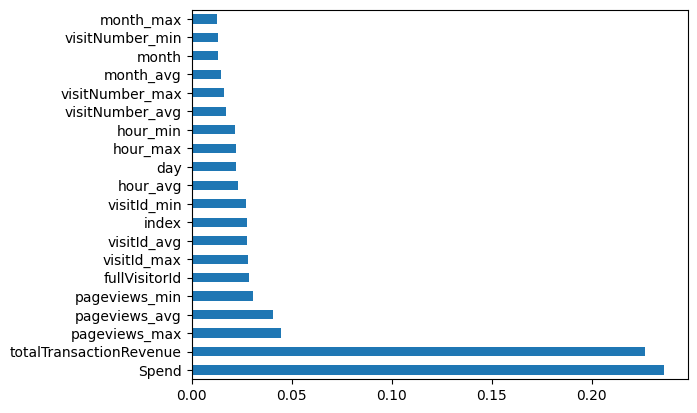

In [ ]:
forest_importances.nlargest(20).plot(kind='barh', fontsize=10)

In [ ]:
columns = list(forest_importances.nlargest(20).index)
columns

['Spend',
 'totalTransactionRevenue',
 'pageviews_max',
 'pageviews_avg',
 'pageviews_min',
 'fullVisitorId',
 'visitId_max',
 'visitId_avg',
 'index',
 'visitId_min',
 'hour_avg',
 'day',
 'hour_max',
 'hour_min',
 'visitNumber_avg',
 'visitNumber_max',
 'month_avg',
 'month',
 'visitNumber_min',
 'month_max']

In [ ]:
top40_df = df[columns]

In [ ]:
top40_df.head()

,Spend,totalTransactionRevenue,pageviews_max,pageviews_avg,pageviews_min,fullVisitorId,visitId_max,visitId_avg,index,visitId_min,hour_avg,day,hour_max,hour_min,visitNumber_avg,visitNumber_max,month_avg,month,visitNumber_min,month_max
0,0,0.0,13.0,13.0,13.0,2.042434e+13,1480578901,1.480579e+09,0,1480578901,7.0,1,7,7,1.0,1,11.0,12,1,11
1,0,0.0,25.0,25.0,25.0,1.740674e+14,1478846641,1.478847e+09,3,1478846641,6.0,11,6,6,1.0,1,11.0,11,1,11
2,0,0.0,2.0,2.0,2.0,2.454374e+14,1472862842,1.472863e+09,5,1472862842,0.0,3,0,0,1.0,1,9.0,9,1,9
3,0,0.0,1.0,1.0,1.0,3.938826e+14,1471737641,1.471738e+09,7,1471737641,0.0,21,0,0,1.0,1,8.0,8,1,8
4,0,0.0,1.0,1.0,1.0,4.854189e+14,1480509787,1.480510e+09,8,1480509787,12.0,30,12,12,1.0,1,11.0,11,1,11


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.linear_model import LogisticRegression
import numpy as np
from sklearn.metrics import r2_score

# Assuming you have a DataFrame called 'final_features' with all the engineered features

# Split the data into training and testing sets
#X_classification = top40_df
#y_classification = top40_df['is_returned']

X_regression = top40_df.drop(['totalTransactionRevenue'], axis=1)
y_regression = top40_df['totalTransactionRevenue']

X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X_classification, y_classification, test_size=0.2, random_state=42)
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_regression, y_regression, test_size=0.2, random_state=42)

# Train the classification model (Logistic Regression as an example)
classifier = LogisticRegression()
classifier.fit(X_train_class, y_train_class)

# Make predictions for binary classification
y_pred_class = classifier.predict(X_test_class)

# Evaluate the classification model
accuracy = accuracy_score(y_test_class, y_pred_class)
print(f'Accuracy of Binary Classification: {accuracy}')


# Feature Scaling
scaler = StandardScaler()
X_train_reg_scaled = scaler.fit_transform(X_train_reg)
X_test_reg_scaled = scaler.transform(X_test_reg)

# Train the Linear regression model
regressor = LinearRegression()
regressor.fit(X_train_reg_scaled, y_train_reg)

# Make predictions for regression
y_pred_reg = regressor.predict(X_test_reg_scaled)

# Evaluate the regression model
mse = mean_squared_error(y_test_reg, y_pred_reg)
print(f'Mean Squared Error of Linear Regression: {mse}')
rmse = np.sqrt(mse)
r2 = r2_score(y_test_reg, y_pred_reg)

print(f'Root Mean Squared Error: {rmse}')
print(f'R-squared score: {r2}')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy of Binary Classification: 0.9999152805625371
Mean Squared Error of Linear Regression: 1214969263464757.2
Root Mean Squared Error: 34856409.216451965
R-squared score: 0.2120712100306935


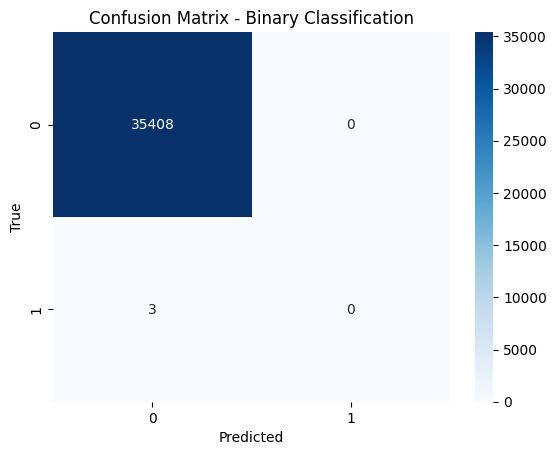

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Classification results visualization
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test_class, y_pred_class)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Binary Classification')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


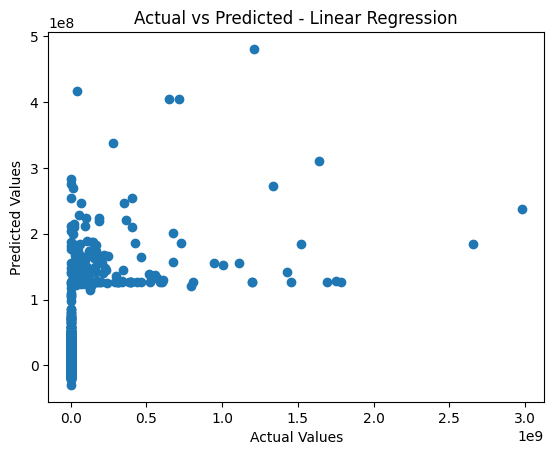

In [ ]:

# Regression results visualization
# Scatter plot of actual vs predicted values
plt.scatter(y_test_reg, y_pred_reg)
plt.title('Actual vs Predicted - Linear Regression')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()


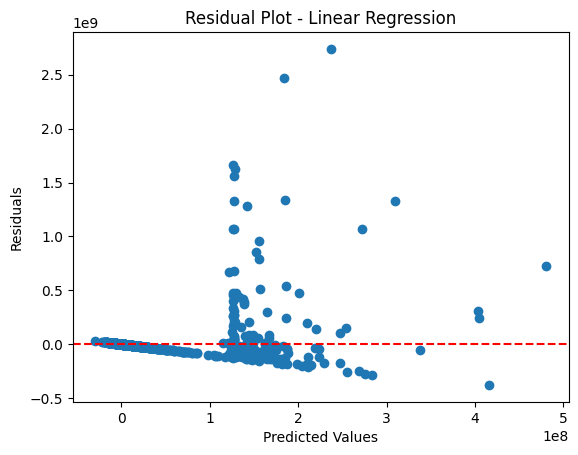

In [ ]:

# Residual plot for regression
residuals = y_test_reg - y_pred_reg
plt.scatter(y_pred_reg, residuals)
plt.title('Residual Plot - Linear Regression')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# Confusion Matrix
conf_matrix = confusion_matrix(y_test_class, y_pred_class)
print("Confusion Matrix:")
print(conf_matrix)

# Classification Report
class_report = classification_report(y_test_class, y_pred_class)
print("Classification Report:")
print(class_report)


Confusion Matrix:
[[35408     0]
 [    3     0]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     35408
           1       0.00      0.00      0.00         3

    accuracy                           1.00     35411
   macro avg       0.50      0.50      0.50     35411
weighted avg       1.00      1.00      1.00     35411



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
forest = RandomForestClassifier(random_state=0)
forest.fit(X_classification, y_classification)
importances= forest.feature_importances_
feature_names=X_train_reg.columns
forest_importances_cl = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity", fontsize=10)
fig.tight_layout()
plt.show()

ValueError: ignored

In [ ]:
forest_importances_cl.nlargest(20).plot(kind='barh', fontsize=10)

In [ ]:
train_df1['date'] = pd.to_datetime(train_df1['date']).astype('int64')

In [ ]:
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

# Assuming df1 is your DataFrame with 'totalTransactionRevenue' and other features
# You may need to preprocess your data accordingly

# Split the data into features (X) and target variable (y)
y = df['totalTransactionRevenue']
X = df.drop(['totalTransactionRevenue'], axis = 1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#y_train = small_train_df_tst['totalTransactionRevenue']
#X_train = small_train_df_tst.drop('totalTransactionRevenue', axis=1)
# Add a constant term to the features for the intercept (only for training sets)
X_train_final = sm.add_constant(X_train)
X_test_final = sm.add_constant(X_test)

# Standardize the features (optional but often recommended)
scaler = StandardScaler()
X_train_final_scaled = scaler.fit_transform(X_train_final)
X_test_final_scaled = scaler.transform(X_test_final)

# Fit the GLM
glm_model = sm.GLM(y_train, X_train_final_scaled, family=sm.families.Gaussian())
glm_results = glm_model.fit()

# Display the summary of the GLM
print(glm_results.summary())

# Make predictions on the test set
y_pred = glm_results.predict(X_test_final_scaled)

In [ ]:
r_2 = r2_score(y_test, y_pred)
print(r_2)

In [ ]:
# Split the data into features (X) and target variable (y)
y = df['totalTransactionRevenue']
X = df.drop(['revenue', 'totalTransactionRevenue'],  axis=1)

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.metrics import r2_score

In [ ]:
# Creating and fitting the model using the training data
model = LinearRegression()
model.fit(X_train, y_train)

# Making predictions on the test set
y_pred = model.predict(X_test)

# Calculating metrics on the test set
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R-squared score: {r2}')

In [ ]:
forest = RandomForestClassifier(random_state=0)
forest.fit(X_train, y_train)
importances = forest.feature_importances_
feature_names=X_train.columns
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity", fontsize=10)
fig.tight_layout()
plt.show()

In [ ]:
forest_importances.nlargest(10).plot(kind='barh', fontsize=10)

In [ ]:
cols = forest_importances.nlargest(10).index

In [ ]:
from google.colab import files
clean_X_train.to_csv('clean_X_train.csv', index=False)
files.download('clean_X_train.csv')


In [ ]:
clean_y_train.to_csv('clean_y_train.csv', index=False)
files.download('clean_y_train.csv')

In [ ]:
from google.colab import files
clean_X_test.to_csv('clean_X_test.csv', index=False)
files.download('clean_X_test.csv')
clean_y_test.to_csv('clean_y_test.csv', index=False)
files.download('clean_y_test.csv')